## Tutorial 3: Noise pertubation

In this Tutorial 3, we will demonstrate the application of variable operators in cupsm by exemplarily applying a white noise operator to model simulation data (`sim_data`). Before you start, please make sure you are familiar with the contents of Tutorial 1 "Getting Started" and Tutorial 2 "Forward modelling of proxy timeseries".

### 0. Preparations

For this Example, we can use the same simulation data that was used in Tutorial 2, i.e. climate model output of a transient simulation of the last deglaciation performed with MPI-ESM-CR-1.2 using the GLAC1D ice sheet reconstruction as boundary conditions (see [publication](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021GL096767) for more details). For instructions on downloading and regridding the data please check Tutorial 2.

To access the data we need to set the path to the directory to which the regridded simulation data was previously saved (see Tutorial 2):

In [1]:
# define path
sim_data_path = "/data/projects/nfdi4earth/regridded_tos_mpi-esm/" # path where the netcdf files of the simulation data are

As in Tutorial 2, we eventually want to create a forward proxy time series from our simulation data. To do this, we set a path to the LiPD files and the proxy overview table. The latter, was created in Tutorial 1 and contains the meta information of the LiPD files of the [PALMOD 130k marine palaeoclimate data synthesis V1_0_1](https://doi.org/10.1594/PANGAEA.914466) dataset (see the related [publication](https://essd.copernicus.org/articles/12/1053/2020/) and refer to Tutorial 1 for download instructions).

In [2]:
# define paths
lipd_path = "/data/obs/proxy_databases/PalMod130k/PALMOD130k_v1_0_1_250320/LiPD/" # path to directory where LiPD files are 
table_path = "/data/projects/nfdi4earth/" # path where the overview table was stored in Tutorial 1

Next, we import the necessary packages.

In [3]:
# import packages
import pandas as pd
import numpy as np
import xarray as xr

# import cupsm
# since cupsm is only available on GitHub, 
# you need to expand your python path variable 
# to the code directory for this notbook session
import sys
sys.path.append('../') # here, it will be the parent direcory
import cupsm
# import a function from the tutorial code bits
from tutorials.utilities_sst_example import transfer_timeaxis_deglac, plot_results

# import plotting packages
import matplotlib
import matplotlib.pyplot as plt

### 1. Initialize sim data and select a 1000 year time slice

Applying what we have learned in Tutorial 2, we load the simulation data using xarray's `open_mfdataset` function, enabling parallelized file opening via dask by setting the keyword `parallel=True`.

In [4]:
# Load deglaciation data
sim_data = xr.open_mfdataset(f"{sim_data_path}*.nc", parallel=True, use_cftime=True,)

As before, we then select the sea surface temperature variable (`tos`) and apply the transfer_timeaxis_deglac function to appropriately transfer the time axis specifically for the data in our example. The resulting time axis covers a time span from 25 to 0 kiloyears before present (BP).

In [5]:
# apply the time axis transformation and chose our variable `tos`
sim_data = transfer_timeaxis_deglac(sim_data.tos)

For exploring the white noise operator, we choose a short section of the `sim_data`.

In [23]:
# select 1000 years of sim_data for our example #10-9 ka BP
example_sim_data = sim_data.where(sim_data['time.year'].isin(np.arange(10000,9000,-1)), drop=True)
example_sim_data

<xarray.DataArray 'tos' (time: 12000, lat: 101, lon: 122)>
dask.array<where, shape=(12000, 101, 122), dtype=float64, chunksize=(1200, 101, 122), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.2 -86.4 -84.6 -82.8 ... 84.6 86.4 88.2 90.0
  * lon      (lon) float64 -180.0 -177.0 -174.1 -171.1 ... 171.1 174.1 177.0
  * time     (time) object 10000-01-16 12:00:00 ... 9001-12-16 12:00:00

### 2. Adding white noise to the `sim_data`

By applying variable operators in cupsm, new ensemble members can be generated: The white noise operator (`cupsm.white_noise`) does this by first creating the noise in question and then adding it to the original input data, saving the result as a new ensemble member. A chosen number of new ensemble members can be generated.

Here we will exemplarily apply cupsm.white_noise to our example_sim_data. By setting `num_ensemble=4`, we request four new ensemble members to be generated.

In [8]:
cupsm.white_noise?

Signature: cupsm.white_noise(sim_data, num_ensemble, mu=0, sigma=1)
Docstring:
Creates white noise by filling an array in shape of the input data
with randomly drawn values from a normal (Gaussian) distribution. 
Adds this white noise to the input data and saves the result as a new
(white noise) ensemble member. 

Multiple new ensemble members can be created. The original input
data is kept as the first ensemble member. 

The result is returned as a xarray Dataarray.

Parameters:
----------
sim_data      : xarray Datarray; input data (e.g. simulation data)
num_ensemble  : integer; number of additional white noise ensemble members to be created.
mu            : float; mean of the normal distribution. Default is mu=0.
sigma         : float; standard deviation of the normal distribution. Default is sigma=1.
File:      ~/Code/Python/cupsm/cupsm/variable_operators.py
Type:      function

In [9]:
# create 4 new noisy ensemble members for sim_data by adding white noise
example_sim_data_wn=cupsm.white_noise(example_sim_data,num_ensemble=4) 
example_sim_data_wn

<xarray.DataArray 'tos' (ensemble_member: 5, time: 12000, lat: 101, lon: 122)>
dask.array<setitem, shape=(5, 12000, 101, 122), dtype=float64, chunksize=(1, 1200, 101, 122), chunktype=numpy.ndarray>
Coordinates:
  * lat              (lat) float64 -90.0 -88.2 -86.4 -84.6 ... 86.4 88.2 90.0
  * lon              (lon) float64 -180.0 -177.0 -174.1 ... 171.1 174.1 177.0
  * time             (time) object 10000-01-16 12:00:00 ... 9001-12-16 12:00:00
  * ensemble_member  (ensemble_member) int64 0 1 2 3 4

Note that after the application of the white noise operator, a new dimension `ensemble_member` was created. The output array now contains five ensemble members - four newly created noisy ones and the original `example_sim_data`, which is kept as the first ensemble member.

Let's visualize the difference between `example_sim_data` and `example_sim_data_wn` (with ensemble members e) by plotting their tos variable side by side for the first 100 steps (months) of the time axis (starting at 1000 years BP) for an arbitrary chosen location (here at latitude 0°N and longitude 0°E). 

Location: 0.0 °N, 0.0 °E


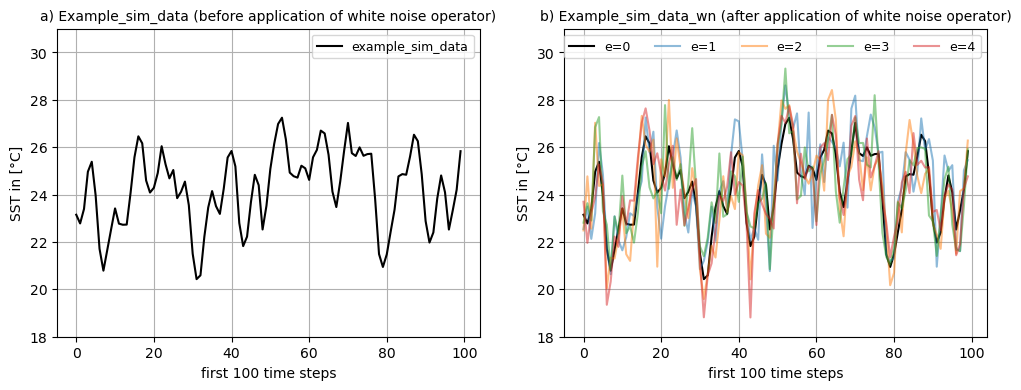

In [10]:
# Plot 
lat_ind=50; lon_ind=61
print(f"Location: "+str(example_sim_data.lat.values[lat_ind])+" °N, "+str(example_sim_data.lon.values[lon_ind])+" °E")
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("a) Example_sim_data (before application of white noise operator)",fontsize=10)
plt.plot(example_sim_data[0:100,lat_ind,lon_ind],color="black",label="example_sim_data")
plt.ylim(18,31);plt.grid();plt.legend(fontsize=9)
plt.xlabel("first 100 time steps"), plt.ylabel("SST in [°C]")
plt.subplot(1,2,2)
plt.title("b) Example_sim_data_wn (after application of white noise operator)",fontsize=10)
plt.plot(example_sim_data_wn[0,0:100,lat_ind,lon_ind],color="black",label="e=0")
for e in range(1,5):
    plt.plot(example_sim_data_wn[e,0:100,lat_ind,lon_ind],alpha=0.5,label="e="+str(e))
plt.grid();plt.ylim(18,31);plt.legend(fontsize=9,ncol=5)
plt.xlabel("first 100 time steps");plt.ylabel("SST in [°C]")
plt.show()

## 2. Initialize example site and its target

For this example, we will again select an example site from our list of LiPD sites (see Tutorial 1). Let's use `cupsm.get_records_df` to load the overview table and print the meta data of the chosen site `MD98_2181.lpd`.

In [11]:
# load the overview table
proxy_overview_table = cupsm.create_proxy_info(database_path=lipd_path, save_path=table_path)
# create site_object 
example_site = cupsm.get_records_df(df=proxy_overview_table, file_name="MD98_2181.lpd")
# print out info
example_site.info()

The .proxy_meta_data.pkl file is already present in /data/projects/nfdi4earth/ and is returned.
For updating the file, run with the update=True

marine sediment record MD98_2181 (0.07 - 28.01 ka)
Position: lon=125.8274°E, lat=6.3°N, elevation=-2114m
available datasets:
['depth_merged', 'age', 'age-1', 'benthic.d13C', 'benthic.d18O', 'benthic.d13C-1', 'benthic.d18O-1', 'benthic.d13C-2', 'benthic.d18O-2', 'benthic.d13C-3', 'benthic.d18O-3', 'benthic.d13C-4', 'benthic.d18O-4', 'age-2', 'planktonic.d18O', 'planktonic.MgCa', 'surface.temp', 'benthic.d18O-5', 'age-3', 'planktonic.MgCa-1', 'surface.temp-1', 'planktonic.d13C', 'planktonic.d18O-1', 'planktonic.d13C-1', 'planktonic.d18O-2', 'planktonic.MgCa-2', 'surface.temp-2', 'benthic.d18O-6']
            


As in tutorial 2, we need to initialize a target. This time we chose the variable `surface_temp_1` and an unknown habitatSeason (is considered to be annual in the end, to keep potential biases small).

In [15]:
# initialize target
example_site.create_target(record_var="surface_temp_1", sim_var="tos", habitatSeason="unknown")

 ## 3. Apply Operators

Next, we want to use the space operator to map the spatial field of `example_sim_data_wn` onto the spatial structure of the `site_object`.
Therefore, we define the following function that applies `cupsm.field2site` to each ensemble member individually, iterating through all ensemble members.

In [16]:
def apply_space(site_object,data):
    if 'ensemble_member' in data.coords and data.ensemble_member.ndim!=0:
        a=[]
        for i in data.ensemble_member.values: 
             a.append(cupsm.field2site(data.sel(ensemble_member=i), site_object, radius_km=300))
        a=xr.concat(a,dim="ensemble_member")
    else:
        a=cupsm.field2site(data, site_object, radius_km=300)
    return a

In [17]:
# apply space_operator to example_sim_data_wn for example_site
example_sim_data_wn2site=apply_space(example_site,example_sim_data_wn).compute()
example_sim_data_wn2site

<xarray.DataArray 'tos' (ensemble_member: 5, time: 12000)>
array([[27.4884405 , 27.13882707, 27.17627556, ..., 29.32636391,
        29.06147225, 28.14666154],
       [27.56336388, 26.42915378, 27.15946136, ..., 29.11008445,
        29.07747529, 27.54475609],
       [27.8214775 , 26.5777022 , 27.66695016, ..., 28.99119555,
        28.77859032, 27.86508282],
       [28.2839144 , 27.18930108, 26.81646218, ..., 29.58351662,
        27.51055086, 27.68196983],
       [27.05211052, 27.4247716 , 27.32935215, ..., 29.2833263 ,
        28.79529527, 28.53257862]])
Coordinates:
  * time             (time) object 10000-01-16 12:00:00 ... 9001-12-16 12:00:00
  * ensemble_member  (ensemble_member) int64 0 1 2 3 4
Attributes:
    lon:      125.8274
    lat:      6.3

Well done! Now after the spatial mapping, we have once again obtained five ensemble members (e): the first is created from the original example_sim_data (equal to the first ensemble member of `example_sim_data_wn`) without additional white noise and the other four ensemble members are created from the noisy ensemble members of `example_sim_data_wn`. 

To visualize this let us again plot the `tos` variable for the different ensemble members of the `example_sim_data_wn` against the first 100 time steps of the time axis.

Location: 6.3 °N, 125.8274 °E


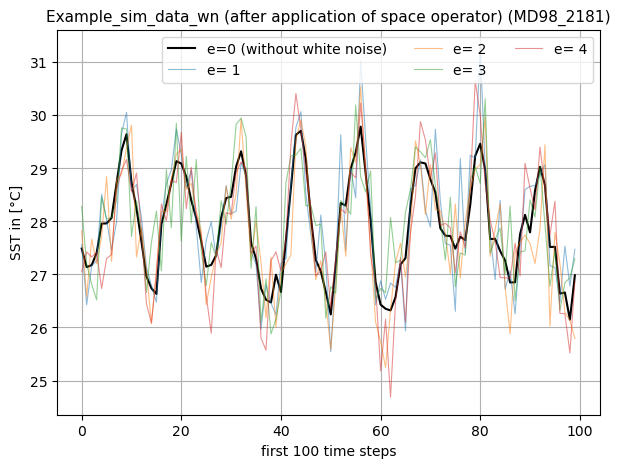

In [19]:
#Plot
fig=plt.figure(figsize=(7,5))
x,y,_=example_site.coords
plt.title(f"Example_sim_data_wn (after application of space operator) ({str(example_site.site_name)})",fontsize=11)
plt.plot(example_sim_data_wn2site[0,0:100],color="black",label="e=0 (without white noise)")
for i in range(1,5): #noisy ensemble members
    plt.plot(example_sim_data_wn2site[i,0:100],linewidth=0.8,alpha=0.5,label="e= "+str(i))
plt.grid()
plt.legend(ncol=3)
plt.xlabel("first 100 time steps")
plt.ylabel("SST in [°C]")
print("Location: "+str(y)+" °N, "+str(x)+" °E")

## 3. Apply chron operator

As demonstrated in Tutorial 2, we will now apply the chronologies operator `cupsm.time2chron` to map the example_sim_data_wn2site time axis onto the irregular example_site time axis. 

You will note that the shape of the output (i.e. the forward proxy timeseries) remains the same, independent of the number of ensemble members of `example_sim_data_wn2site` selected for the input of the chronologies operator. This is because `cupsm.time2chron` - given the case that the simulation input contains more than one ensemble member - pairs each proxy age ensemble member with one randomly selected simulation ensemble member (excluding the first one that does not contain white noise), thereby propagating the additionally created (white noise) uncertainty to the forward proxy timeseries. Nice, right?

In [24]:
# apply chronologies operator # to only the first ensemble member of example_sim_data_wn2site 
example_fwd = cupsm.time2chron(example_sim_data_wn2site[0], site_object=example_site, quiet=True)
example_fwd

<xarray.DataArray 'tos' (depth: 70, ens: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * depth    (depth) float64 6.21 6.25 6.29 6.31 6.33 ... 8.73 8.75 8.77 8.79
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
Attributes:
    site:     MD98_2181
    lon:      125.8274
    lat:      6.3

In [25]:
# apply chronologies operator # to example_sim_data_wn2site (with all five ensemble members)
example_wn_fwd = cupsm.time2chron(example_sim_data_wn2site, site_object=example_site, quiet=True)
example_wn_fwd

<xarray.DataArray 'tos' (depth: 70, ens: 1000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * depth    (depth) float64 6.21 6.25 6.29 6.31 6.33 ... 8.73 8.75 8.77 8.79
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
Attributes:
    site:     MD98_2181
    lon:      125.8274
    lat:      6.3

We can visualize both cases in the plot below: It shows the forward modeled proxy timeseries of SST vs. depth in terms of the age ensemble median created from `sim_data` with (in blue) and without (in black) additional white noise ensemble members.

Text(0, 0.5, 'SST [°C]')

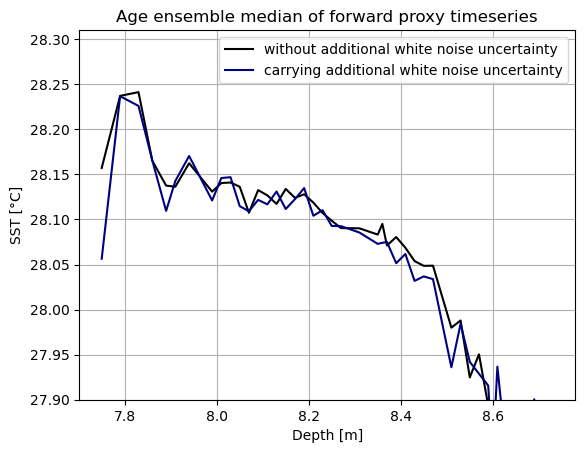

In [27]:
# Plot
# create mask, that at least 5 ensemble members contain data
mask_fwd = ((~ np.isnan(example_fwd)).sum("ens") >= 5)
mask_fwd_wn = ((~ np.isnan(example_wn_fwd)).sum("ens") >= 5)
depth_masked_fwd = example_fwd.depth[mask_fwd]
depth_masked_fwd_wn=example_wn_fwd.depth[mask_fwd_wn]
# plot median
plt.plot(depth_masked_fwd, example_fwd.median("ens")[mask_fwd], color="black", label="without additional white noise uncertainty")
plt.plot(depth_masked_fwd_wn,example_wn_fwd.median("ens")[mask_fwd_wn],color="navy",label="carrying additional white noise uncertainty")
plt.grid() 
plt.ylim(27.9,28.31);plt.legend()
plt.title("Age ensemble median of forward proxy timeseries")
plt.xlabel("Depth [m]");plt.ylabel("SST [°C]")

**You have succesfully completed Tutorial 3. Well done! =)**